In [25]:
import numpy as np

# 평가

- 성능 평가 지표는 일반적으로 모델이 분류냐 회귀냐에 따라 여러 종류로 나뉨


- 회귀의 경우 대부분 실제값과 예측값의 오차 평균값에 기반 <br>
: 예를 들어, 오차에 절댓값을 씌운 뒤 평균 오차를 구하기<br>
: 오차의 제곱 값에 루트를 씌운 뒤 평균 오차를 구하기 <br>



- 분류의 평가 방법도 일반적으로 실제 결과 데이터와 예측 결과 데이터가 얼마나 정확하고 오류가 적게 발생하는가에 기반하지만,<br>
  단순히 이러한 정확도만 가지고 판단했다가는 잘못된 평가 결과에 빠질 수 있음 

### 분류

**분류의 성능 평가 지표**
- 정확도
- 오차행렬
- 정밀도
- 재현률
- FI 스코어
- ROC AUC


2진분류 : 결정 클래스 값 종류의 유형에 따라 긍정/부정과 같은 2개의 결과값만을 가짐<br>
멀티분류 : 여러 개의 결정 클래스 값을 가짐

## 1. 정확도 

정확도 = 예측 결과가 동일한 데이터 건수 / 전체 예측 데이터 건수 <br>
 ; 직관적으로 모델 예측 성능을 나타내는 지표 <br>
 ; 하지만 이진 분류의 경우 데이터의 구성에 따라 ML 모델의 성능을 왜곡할 수 있기 때문에 정확도 수치 하나만 가지고 성능을 평가하지 않음 <br>
 
 ; 또한 특히 정확도는 불균형한 레이블 값 분포에서 ML 모델의 성능을 판단할 경우, 적합한 평가지표가 아님<br>
예를 들어 100개의 데이터가 있고 이 중에 90개의 데이터 레이블이 0, 단 10개의 데이터 레이블이 1이라고 한다면 무조건 0으로 예측 결과를 반환하는 ML 모델의 경우라도 정확도가 90%


왜곡예시-1 ) 타이타닉 예제

ML 알고리즘을 적용한 후 예측 정확도의 결과가 보통 80%대였지만, 탑승객이 남자인 경우보다 여자인 경우에 생존 확률이 높았기 때문에 <br>
별다른 알고리즘의 적용 없이 무조건 성별이 여자인 경우 생존으로, 남자의 경우 사망으로 예측 결과를 예측해도 이와 비슷한 수치가 나올 것 <br>
-> 단지 성별 조건 하나만만을 가지고 결정하는 별거 아닌 알고리즘도 높은 정확도를 나타내는 상황이 발생하는 것 <br>

In [26]:
# 사이킷런은 BaseEstimator를 상속받으면 Customized 형태의 Estimator를 개발자가 생성할 수 있음
# 생성할 MyDummyClassifier 클래스는 학습을 수행하는 fit() 메서드는 아무것도 수행하지 않으며, 
# 예측을 수행하는 predict() 메서드는 단순히 sex 피처가 1이면 0, 그렇지 않으면 1로 예측하는 매우 단순한 Classifier

from sklearn.base import BaseEstimator

class MyDummyClassifier(BaseEstimator):
    #fit() 메서드는 아무것도 수행하지 않음.
    def fit(self, X, y=None):
        pass
    def predict(self,X):
        pred = np.zeros((X.shape[0],1))
        for i in range(X.shape[0]):
            if X["Sex"].iloc[i] == 1:
                pred[i] = 0
            else:
                pred[i] = 1
        return pred

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할

titanic_df = pd.read_csv("/Users/ijiseon/Desktop/데이터/titanic_train.csv")
y_titanic_df = titanic_df["Survived"]
X_titanic_df = titanic_df.drop("Survived",axis=1)

In [17]:
X_titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Name         891 non-null    object 
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


In [18]:
#Null 처리함수 

def fillna(df):
    df["Age"].fillna(df["Age"].mean(),inplace=True)
    df["Cabin"].fillna("N",inplace=True)
    df["Embarked"].fillna("N",inplace=True)
    df["Fare"].fillna(0,inplace=True)
    return df

#머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
    df.drop(["PassengerId","Name","Ticket"],axis=1, inplace=True)
    return df

#레이블 인코딩 수행
def format_features(df):
    from sklearn.preprocessing import LabelEncoder
    df["Cabin"] = df["Cabin"].str[:1]
    features = ["Cabin","Sex","Embarked"]
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

#앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [19]:
X_titanic_df = transform_features(X_titanic_df)

In [20]:
X_titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    int64  
 2   Age       891 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
 6   Cabin     891 non-null    int64  
 7   Embarked  891 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 55.8 KB


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=0)

In [27]:
myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)

mypredictions = myclf.predict(X_test)
print("Dummy Classifier의 정확도는 : {0:.4f}".format(accuracy_score(y_test, mypredictions)))

Dummy Classifier의 정확도는 : 0.7877


왜곡예시 -2 ) MNIST 데이터세트 <br>
: MNIST 데이터 세트는 원래 0부터 9까지의 숫자 이미지의 픽셀 정보를 가지고 있으며, 이를 기반으로 숫자 digit을 예측하는데 사용 <br>
: 사이킷런은 load_digits() API를 통해 MNIST 데이터 세트를 제공. <br>
: 원래 MNIST 데이터 세트는 레이블 값이 0부터 9까지 있는 멀티 레이블 분류를 위한 것<br> 
-> 이것을 레이블 값이 7인 것만 True, 나머지값은 False로 변환해 이진 분류 문제로 바꾸겠음<br>
;; 전체의 데이터의 10%만 "True", 나머지 90%는 "False"인 불균형한 데이터 세트로 변형하는 것 <br>

이때, 모든 데이터를 False 즉 0으로 예측하는 classifier를 이용해 정확도를 측정하면 약 90%에 가까운 예측 정확도를 나타냄<br>
즉, 아무것도 하지 않고 무조건 특정한 결과로 찍어도 데이터 분포도가 균일하지 않은 경우 높은 수치가 나타날 수 있는 것이 정확도 평가 지표의 맹점<br>

In [34]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

class MyFakeClassifier(BaseEstimator):
    def fit(self,X,y):
        pass
    
    #입력값으로 들어오는 X 데이터 세트의 크기만큼 모두 0값으로 만들어서 반환
    def predict(self,X):
        return np.zeros((len(X),1),dtype=bool)

#사이킷런의 내장 데이터 세트인 load_digits()를 이용해 MNIST 데이터 로딩
digits = load_digits()

#digits 번호가 7번이면 True이고 이를 astype(int)로 1로 변환, 7번이 아니면 False이고 0으로 변환
y = (digits.target==7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data , y, random_state=11)

In [35]:
# 불균형한 레이블 데이터 분포도 확인
print("레이블 테스트 세트 크기 :", y_test.shape)
print("테스트 세트 레이블 0과 1의 분포도")
print(pd.Series(y_test).value_counts())

레이블 테스트 세트 크기 : (450,)
테스트 세트 레이블 0과 1의 분포도
0    405
1     45
dtype: int64


In [36]:
# Dummy Classifier로 학습/예측/정확도 평가

fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fakepred = fakeclf.predict(X_test)

print("모든 예측을 0으로 하여도 정확도는:{:.3f}".format(accuracy_score(y_test,fakepred)))

모든 예측을 0으로 하여도 정확도는:0.900


## 2. 오차 행렬

이진 분류에서 성능 지표로 잘 활용되는 오차행렬(confusion matrix)은 학습된 분류 모델이 예측을 수행하면서 얼마나 헷갈리고 있는지도 함께 보여줌<br>
즉, 이진 분류의 예측 오류가 얼마인지와 더불어 어떠한 유형의 예측 오류가 발생하고 있는지를 함께 나타내는 지표 <br>

- TN (True Negative) : 예측값을 negative 값 0으로 예측했고 실제 값 역시 negative 값 0
- FP (False Positive): 예측값을 positive 값 1로 예측했는데 실제 값은 negative 값 0
- FN (False Negative) : 예측값을 negative 값 0으로 예측했는데 실제 값은 positive 값 0
- TP (True Positive): 예측값을 positive 값 1로 예측했고 실제 값 역시 positive 값 0

이 값을 조합해 Classifier의 성능을 측정할 수 있는 주요 지표인 정확도, 정밀도, 재현율 값을 알 수 있음 <br>
정확도 = 예측 결과와 실제 값이 동일한 건수/전체 데이터수  = (TN+TP) / (TN+TP+FP+FN)

In [43]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, fakepred)

array([[405,   0],
       [ 45,   0]])

MyFakeClassifier는 무조건 Negative로 예측하는 Classifier<br>
; 테스트 데이터 세트의 클래스 값 분포는 0이 405건, 1이 45건 <br>
따라서 TN은 전체 450건 중 무조건 negative 0으로 예측해서 True가 된 결과 405건 <br>
FP는 positive 1로 예측한 건수가 없으므로 0건 <br>
FN은 positive 1인 건수 45건을 negative로 예측해서 false가 된 결과 45건 <br>
TP는 positive 1로 예측한 건수가 없으므로 0건 <br>

### 불균형한 레이블 클래스를 가지는 이진 분류 모델

일반적으로 불균형한 레이블 클래스를 가지는 이진 분류 모델에서는 <br>
많은 데이터 중에서 중점적으로 찾아야 하는 매우 적은 수의 결괏값에 positive를 설정해 1값을 부여하고, <br>
그렇지 않은 경우에는 negative로 0값을 부여하는 경우가 많음<br>

예1) 사기 행위 예측 모델에서 사기행위가 양성1 <-> 정상행위가 음성 0<br>
예2) 암 검진 예측 모델에서 암이 양성일 경우 1 <-> 암이 음성일 경우 0<br>

불균형한 이진 분류 데이터 세트에서는 positive 데이터 건수가 매우 작기 때문에,<br>
데이터에 기반한 ML 알고리즘은 positive 보다는 negative로 예측 정확도가 높아지는 경향 발생 <br>

즉, TN은 매우 커지고 TP는 매우 작아짐<br>
또한 negative로 예측할 때 정확도가 높기 때문에 FN(negative로 예측할 때 틀린 데이터 수)이 매우 작고, <br>
Positive로 예측하는 경우 자체가 작기 때문에 FP 역시 매우 작아짐 

**결과적으로 정확도 지표는 비대칭한 데이터 세트에서 Positive에 대한 예측 정확도를 판단하지 못한 채, <br>
negative에 대한 예측 정확도만으로도 분류의 정확도가 매우 높게 나타나는 수치적인 판단 오류를 일으키게 됨** 

-> 정확도는 분류 모델의 성능을 측정할 수 있는 한 가지 요소일 뿐<br>
앞선 사례에서 봤듯, 불균형한 데이터 세트에서 정확도만으로는 (평가하게 되면) 모델 신뢰도가 떨어질 수 있음. 

**불균형한 데이터 세트에서 정확도보다 더 선호되는 평가 지표는 "정밀도와 재현율"**

## 3. 정밀도와 재현율

- TN (True Negative) : 예측값을 negative 값 0으로 예측했고 실제 값 역시 negative 값 0
- FP (False Positive): 예측값을 positive 값 1로 예측했는데 실제 값은 negative 값 0
- FN (False Negative) : 예측값을 negative 값 0으로 예측했는데 실제 값은 positive 값 0
- TP (True Positive): 예측값을 positive 값 1로 예측했고 실제 값 역시 positive 값 0

**정밀도 = TP / (FP+TP)** <br>
: 정밀도는 예측을 positive로 한 대상 중에 예측과 실제 값이 positive로 일치한 데이터의 비율 <br>
: positive 예측 성능을 더욱 정밀하게 측정하기 위한 평가 지표로 '양성 예측도'라고도 불림  <br>
: FP를 낮추는데 초점 

정밀도가 중요 지표인 경우
= 실제 negative 음성인 데이터에 대해, positive 양성으로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우<br>
예1 ) 스펨메일 여부 판단 ; 실제 negative인 일반 메일을 positive인 스팸 메일로 분류할 경우에는 메일을 아예 받지 못함

**재현율 = TP / (FN+TP)** <br>
: 실제 값이 positive인 대상 중에 예측과 실제 값이 positive로 일치한 데이터의 비율 <br>
: 민감도(sensitivity) <br>
: FN(실제 positive, 예측 negative)를 낮추는데 초점 

재현율이 중요 지표인 경우 
= 실제 positive 양성 데이터를 negative로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우 <br>
예1 ) 암 판단 모델 ; 실제 positive인 암 환자를 negative로 판단했을 경우 <br>
예2 ) 금융 사기 적발 모델; 실제 금융거래 사기인 positive 건을 negative로 잘못 판단하면 회사에 미치는 손해가 큼 

In [47]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test,pred)
    print("오차행렬")
    print(confusion)
    print("정확도 :{0:.4f}, 정밀도 :{1:.4f}, 재현율 :{2:.4f}".format(accuracy,precision, recall))

In [49]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

#원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할
titanic_df = pd.read_csv("/Users/ijiseon/Desktop/데이터/titanic_train.csv")
y_titanic_df = titanic_df["Survived"]
X_titanic_df = titanic_df.drop("Survived", axis=1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df,
                                                   test_size=0.2, random_state=11)

lr_clf = LogisticRegression()

lr_clf.fit(X_train,y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차행렬
[[104  14]
 [ 13  48]]
정확도 :0.8492, 정밀도 :0.7742, 재현율 :0.7869


/Users/ijiseon/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### 정밀도/재현율 트레이드 오프 

: 분류하려는 업무의 특성상 정밀도 또는 재현율이 특별히 강조돼야 할 경우 **분류의 결정 임곗값(threshold)을 조정**<br>
하지만 정밀도와 재현율은 상호 보완적인 평가 지표이기 때문에 어느 한쪽을 강제로 높이면 다른 하나의 수치는 떨어지기 쉬움. <br>
이를 "정밀도/재현율의 트레이드오프(trade-off)"라고 부름 

: 사이킷런의 분류 알고리즘은 예측 데이터가 특정 레이블(결정 클래스 값)에 속하는지를 계산하기 위해 먼저 개별 레이블별로 결정 확률을 구함.<br>
그리고 예측 확률이 큰 레이블값으로 예측하게 됨. <br>

예) 이진 분류 모델에서 특정 데이터가 0이 될 확률이 10%, 1이 될 확률이 90%로 예측됐다면,<br>
최종 예측은 더 큰 확률을 가진, 즉 90% 확률을 가진 1로 예측. <br>
일반적으로 이진 분류에서는 이 임곗값을 0.5, 즉 50%로 정하고 이 기준 값보다 확률이 크면 positive, 작으면 negative로 결정 

: 사이킷런은 개별 데이터로 예측 확률을 반환하는 메서드인 predict_proba( )를 제공 <br>
- 입력파라미터 -> predict()메서드와 동일하게 보통 테스트 피처 데이터 세트를 입력<br>
- 반환값 -> 개별 클래스의 예측 확률을 ndarray mxn (m;입력값의 레코드 수, n; 클래스 유형)<br>

**각 열은 캐별 클래스의 예측 확률**<br>
예) 테스트데이터 세트의 표본 개수가 100개이고 예측 클래스 값 유형이 2개이면 100x2 ndarray<br>
첫번째 칼럼은 0 negative의 확률 , 두번째 칼럼은 1 positive의 확률

In [50]:
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print("pred_proba() 결과 shape: {0}".format(pred_proba.shape))
print("pred_proba array에서 앞 3개만 샘플로 추출 \n:", pred_proba[:3])

#예측 확률 array와 예측 결과값 array를 병합(concatenate)해 예측 확률과 결괏값을 한눈에 확인
pred_proba_result = np.concatenate([pred_proba,pred.reshape(-1,1)],axis=1)
print("두개의 class 중에서 더 큰 확률을 클래스 값으로 예측\n", pred_proba_result[:3])

pred_proba() 결과 shape: (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출 
: [[0.46196516 0.53803484]
 [0.87858321 0.12141679]
 [0.87713395 0.12286605]]
두개의 class 중에서 더 큰 확률을 클래스 값으로 예측
 [[0.46196516 0.53803484 1.        ]
 [0.87858321 0.12141679 0.        ]
 [0.87713395 0.12286605 0.        ]]


In [51]:
from sklearn.preprocessing import Binarizer

X = [[1,-1,2],
    [2,0,0],
    [0,1.1,1.2]]

# X의 개별 원소들이 threshold값보다 같거나 작으면 0을, 크면 1을 반환
binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [53]:
from sklearn.preprocessing import Binarizer

# Binarizer의 threshold 설정값. 분류 결정 임곗값임
custom_threshold = 0.5

#predict_proba() 반환값의 두 번째 칼럼, 즉 positive 클래스 칼럼 하나만 추출해 binarizer를 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict) 
#이 값은 앞 예제의 타이타닉 데이터로 학습된 로지스틱 회귀 Classifier 객체에서 호출된 predict()로 계산된 지표 값과 정확히 같음 
#predict()가 predict_proba()에 기반함을 알 수 있음

오차행렬
[[104  14]
 [ 13  48]]
정확도 :0.8492, 정밀도 :0.7742, 재현율 :0.7869


In [54]:
#Binarizer의 threshold 설정값을 0.4로 설정. 즉 분류 결정 임곗값을 0.5에서 0.4로 낮춤

custom_threshold = 0.4
pred_proba_1 = pred_proba[:,1].reshape(-1,1)
binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차행렬
[[98 20]
 [10 51]]
정확도 :0.8324, 정밀도 :0.7183, 재현율 :0.8361


**임곗값을 낮추니 재현율 값이 올라가고 정밀도 값이 떨어짐**

**why?** <br>
분류 결정 임곗값은 positive 예측값을 결정하는 확률의 기준이 됨<br>
확률이 0.5가 아닌 0.4부터 positive로 예측을 더 너그럽게 하기 때문에 임곗값 값을 낮출수록 true 값이 많아짐<br>
; positive 예측값이 많아지면 상대적으로 재현율 값이 높아짐<br>
= 양성 예측을 많이 하다 보니 실제 양성을 음성으로 예측하는 횟수가 상대적으로 줄어들기 때문 <br>

In [55]:
#테스트를 수행할 모든 임곗값을 리스트 객체로 저장
thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    #thresholds list 객체 내의 값을 차례로 iteration하면서 evaluation 수행
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print("임곗값:", custom_threshold)
        get_clf_eval(y_test, custom_predict)
        

get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

임곗값: 0.4
오차행렬
[[98 20]
 [10 51]]
정확도 :0.8324, 정밀도 :0.7183, 재현율 :0.8361
임곗값: 0.45
오차행렬
[[103  15]
 [ 12  49]]
정확도 :0.8492, 정밀도 :0.7656, 재현율 :0.8033
임곗값: 0.5
오차행렬
[[104  14]
 [ 13  48]]
정확도 :0.8492, 정밀도 :0.7742, 재현율 :0.7869
임곗값: 0.55
오차행렬
[[109   9]
 [ 15  46]]
정확도 :0.8659, 정밀도 :0.8364, 재현율 :0.7541
임곗값: 0.6
오차행렬
[[112   6]
 [ 16  45]]
정확도 :0.8771, 정밀도 :0.8824, 재현율 :0.7377


**precision_recall_curve() API**

입력파라미터<br>
- y_true: 실제 클래스값 배열 (배열크기=[데이터 건수])<br>
- probas_pred: Positive 칼럼의 예측 확률 배열 (배열 크기 = [데이터 건수])<br>

반환값<br>
- 정밀도: 임곗값별 정밀도 값을 배열로 반환
- 재현율: 임곗값별 재현율 값을 배열로 반환

예) 타이타닉<br>
인자로 실제 값 데이터 세트와 레이블 값이 1일 때의 예측확률 값  

In [57]:
from sklearn.metrics import precision_recall_curve

#레이블 값이 1일 때의 예측확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

#실제값 데이터 세트와 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print("반환된 분류 결정 임계값 배열의 Shape:", thresholds.shape)

#반환된 임계값 배열 로우가 147건이므로 샘플로 10건만 추출하되, 임계값을 15 step으로 추출
thr_index = np.arange(0,thresholds.shape[0], 15)
print("샘플 추출을 위한 임계값 배열의 index 10개: ", thr_index)
print("샘플용 10개의 임곗값:", np.round(thresholds[thr_index],2))

#15step 단위로 추출된 임계값에 따른 정밀도와 재현율 값
print("샘플 임계값별 정밀도", np.round(precisions[thr_index],3))
print("샘플 임계값별 재현율", np.round(recalls[thr_index],3))

반환된 분류 결정 임계값 배열의 Shape: (143,)
샘플 추출을 위한 임계값 배열의 index 10개:  [  0  15  30  45  60  75  90 105 120 135]
샘플용 10개의 임곗값: [0.1  0.12 0.14 0.19 0.28 0.4  0.56 0.67 0.82 0.95]
샘플 임계값별 정밀도 [0.389 0.44  0.466 0.539 0.647 0.729 0.836 0.949 0.958 1.   ]
샘플 임계값별 재현율 [1.    0.967 0.902 0.902 0.902 0.836 0.754 0.607 0.377 0.148]


In [68]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    #threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precision, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    #x축을 threshold 값으로, Y축은 정밀도, 재현율 값으로 각각 plot 수행. 정밀도는 점선으로 표시 
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle="-", label="precision")
    plt.plot(thresholds, recalls[0:threshold_boundary], label="recall")
    
    #threshold 값 x축의 scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end,0.1),2))
    
    #x축, y출 label과 legend 그리고 grid 설정
    plt.xlabel("Threshold value") 
    plt.ylabel("Precision and recall value")
    plt.legend(); plt.grid()
    plt.show()

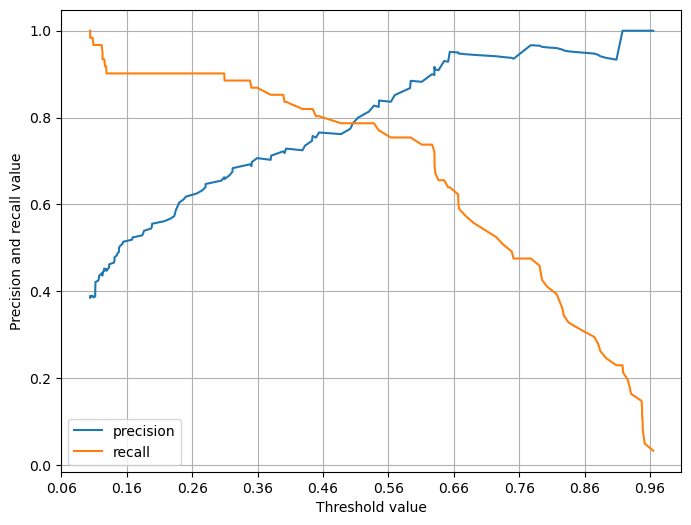

In [69]:
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

## 4. F1 스코어

F1 스코어는 정밀도와 재현율을 결합한 지표 -> 정밀도와 재현율이 어느 한쪽으로 치우치지 않는 수치를 나타날 때 상대적으로 높은 값

F1 = 2/[(1/recall)+(1/precision)] = 2 x [(precision x recall)/ (precision+recall)]

만일 A 예측 모델의 경우 정밀도가 0.9, 재현율이 0.1로 극단적인 차이가 나고, <br>
B 예측 모델은 정밀도가 0.5, 재현율이 0.5로 정밀도와 재현율이 큰 차이가 없다면 <br>

A 예측 모델의 F1 스코어는 0.18이고, B예측모델의 F1 스코어는 0.5로, B모델이 A모델에 비해 매우 우수한 F1스코어를 가지게 됨 

In [71]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, pred)
print("F1 스코어: {0:.4f}".format(f1)) #로지스틱 회귀 기반 타이타닉 생존자 모델

F1 스코어: 0.7805


In [72]:
#타이타닉 생존자 예측에서 임곗값을 변화시키면서 F1 스코어를 포함한 평가 지표 

#get_eval_by_threshold 내 들어있는 get_clf_eval 재정의 

def get_clf_eval(y_test, pred):
    confusion= confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 =f1_score(y_test,pred) # F1스코어 추가 
    print("오차행렬")
    print(confusion)
    print("정확도:{0:.4f},정밀도:{1:.4f},재현율:{2:.4f},F1:{3:.4f}".
         format(accuracy,precision, recall, f1))
    
thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

임곗값: 0.4
오차행렬
[[98 20]
 [10 51]]
정확도:0.8324,정밀도:0.7183,재현율:0.8361,F1:0.7727
임곗값: 0.45
오차행렬
[[103  15]
 [ 12  49]]
정확도:0.8492,정밀도:0.7656,재현율:0.8033,F1:0.7840
임곗값: 0.5
오차행렬
[[104  14]
 [ 13  48]]
정확도:0.8492,정밀도:0.7742,재현율:0.7869,F1:0.7805
임곗값: 0.55
오차행렬
[[109   9]
 [ 15  46]]
정확도:0.8659,정밀도:0.8364,재현율:0.7541,F1:0.7931
임곗값: 0.6
오차행렬
[[112   6]
 [ 16  45]]
정확도:0.8771,정밀도:0.8824,재현율:0.7377,F1:0.8036


## 5. ROC 곡선과 AUC

ROC 곡선 FPR(False Positive Rate)이 변할 때 TPR(TruePositiveRate)이 어떻게 변하는지 나타내는 곡선<br>
FPR을 x축으로, TPR을 Y축으로 잡으면 FPR 변화에 따른 TPR의 변화가 곡선형태로 나타남<br>

REMIND 
- TN (True Negative) : 예측값을 negative 값 0으로 예측했고 실제 값 역시 negative 값 0
- FP (False Positive): 예측값을 positive 값 1로 예측했는데 실제 값은 negative 값 0
- FN (False Negative) : 예측값을 negative 값 0으로 예측했는데 실제 값은 positive 값 0
- TP (True Positive): 예측값을 positive 값 1로 예측했고 실제 값 역시 positive 값 0


민감도와 특이성
- 민감도(TPR)
: TP / (FN+TP) = 민감도 
: 실제값 positive(양성)가 정확히 예측돼야 하는 수준 
: 질병이 있는 사람은 질병이 있는 것으로 양성 판정
- 특이성 (TNR)
: 민감도에 대응하는 지표 
: 실제값 negative(음성)가 정확히 예측돼야 하는 수준
: 질병 없는 건강한 사람이 질병이 없는 것으로 음성 판정 
: TN /(FP+TN)


그리고 ROC 곡선의 x축 기준인 FPR은 FP/(FP+TN)이므로 1-TNR 혹은 1-특이성으로 표현  

**ROC 곡선 그래프 해석**

대각선 - 동전을 무작위로 던져 앞/뒤를 맞추는 랜덤 수준의 이진분류의 ROC 직선 (AUC는 0.5)<br>
ROC 곡선이 가운데 직선과 가까울 수록 성능이 떨어지는 것이며 멀이질수록 성능이 뛰어난 것 <br>

임계값을 변화 -> FPR 변화 ; FPR 값의 변화에 따른 TPR 값 구하는 것 <br>
1) FPR =0 <br>
; 임곗값을 1로 지정 _ positive 예측기준이 매우 높기 때문에 분류기가 임곗값보다 높은 확률을 가진 데이터를 positive로 예측할 수 없음 <br>
; FPR = FP /(FP+TN) -> 아예 positive로 예측하지 않기 때문에 FP 값이 0 <br>
2) FPR=1 <br>
; TN=0으로 만들면 됨 <br>
-> 분류 결정 임곗값 0으로 지정 _ 분류기의 positive 확률 기준이 너무 낮아서 다 positive로 예측<br>
그럼 아예 negative 예측이 없기 때문에 TN=0 이 됨<br>

**roc_curve() API**

입력파라미터<br>
- y_true: 실제 클래스값 array (array shape=[데이터 건수])<br>
- y score: predict_proba()의 반환 값 array에서 positive 칼럼의 예측 확률이 보통 사용됨 (array.shape=[n_samples])<br>

반환값<br>
- fpr: fpr 값을 array로 반환
- tpr: tpr 값을 array로 반환
- thresholds: threshold 값 array


In [73]:
from sklearn.metrics import roc_curve

#레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)
#반환된 임곗값 배열 로우가 47건이므로 샘플로 10건만 추출하되, 임곗값을 5step으로 추출. 
#thresholds[0]은 max(예측확률)+1로 임의 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작
thr_index = np.arange(1, thresholds.shape[0],5)

print("샘플 추출을 위한 임곗값 배열의 index 10개:",thr_index)
print("샘플용 10개의 임곗값:", np.round(thresholds[thr_index],2))

#5 step 단위로 추출된 임계값에 따른 FPR, TPR 값
print("샘플 임곗값별 FPR: ", np.round(fprs[thr_index],3))
print("샘플 임곗값별 TPR: ", np.round(tprs[thr_index],3))

샘플 추출을 위한 임곗값 배열의 index 10개: [ 1  6 11 16 21 26 31 36 41 46 51]
샘플용 10개의 임곗값: [0.97 0.65 0.63 0.56 0.45 0.4  0.35 0.15 0.13 0.11 0.11]
샘플 임곗값별 FPR:  [0.    0.017 0.034 0.076 0.127 0.169 0.203 0.466 0.585 0.686 0.797]
샘플 임곗값별 TPR:  [0.033 0.639 0.721 0.754 0.803 0.836 0.885 0.902 0.934 0.967 0.984]


In [80]:
def roc_curve_plot(y_test, pred_proba_c1):
    #임곗값에 따른 FPR, TPR 값을 반환받음
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    #ROC 곡선을 그래프 곡선으로 그림
    plt.plot(fprs,tprs, label="ROC")
    #가운데 대각선 직선을 그림
    plt.plot([0,1],[0,1],"k--", label="Random")
    
    #FPR X축의 scale을 0.1 단위로 변경, x축, y축 명 설정 등
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel("FPR(1-sensitivity)")
    plt.ylabel("TPR(Recall)")
    plt.legend()

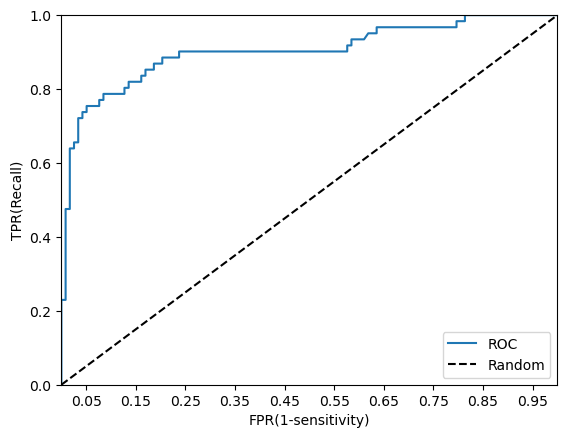

In [81]:
roc_curve_plot(y_test, pred_proba[:,1])

일반적으로 ROC 곡선 자체는 FPR과 TPR의 변화 값을 보는 데 이용하며, <br>
분류의 성능 지표로 사용되는 것은 ROC 곡선 면적에 기반한 AUC 값으로 결정

AUC(Area Under Curve) 값은 ROC 곡선 밑의 면적을 구한 것으로서 일반적으로 1에 가까울수록 좋은 수치 <br>
; AUC 수치가 커지려면 FPR이 작은 상태에서 얼마나 큰 TPR을 얻을 수 있느냐가 관건 

In [86]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score
import numpy as np

print(confusion_matrix(y_test, pred))
print("정확도:", np.round(accuracy_score(y_test,pred),4))
print("정밀도:", np.round(precision_score(y_test,pred),4))
print("재현율:", np.round(recall_score(y_test,pred),4))

[[104  14]
 [ 13  48]]
정확도: 0.8492
정밀도: 0.7742
재현율: 0.7869


In [89]:
#타이타닉 생존자 예측에서 임곗값을 변화시키면서 F1 스코어를 포함한 평가 지표 

#get_eval_by_threshold 내 들어있는 get_clf_eval 재정의 

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion= confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 =f1_score(y_test,pred) 
    roc_auc= roc_auc_score(y_test, pred_proba) #ROC-AUC 추가
    print("오차행렬")
    print(confusion)
    print("정확도:{0:.4f},정밀도:{1:.4f},재현율:{2:.4f},\
    F1:{3:.4f}, AUC:{4:.4f}".format(accuracy,precision, recall, f1,roc_auc))